In [7]:
import pandas as pd
import numpy as np

data = pd.read_csv('full_diplom.csv', low_memory=False) #считываем данные

#***предобработка данных***
#print(223585 - data.count(axis = 0)) # получаем количество пропусков в столбцах
data = data.fillna('0') # заменяем неопределенные значения на нули
data['contentLength'] = data['contentLength'].map(lambda x: 0 if x == '0' else x)
uh = np.unique(data['connection'].values.ravel()) #смотрим уникальные значения в столбце connection
#print(uh)
uh = np.unique(data['userAgent'].values.ravel())#смотрим уникальные значения в столбце userAgent
#print(uh)
uh = np.unique(data['protocol'].values.ravel())#смотрим уникальные значения в столбце protocol
#print(uh)
uh = np.unique(data['pragma'].values.ravel())#смотрим уникальные значения в столбце pragma
#print(uh)
uh = np.unique(data['cacheControl'].values.ravel())#смотрим уникальные значения в столбце cacheControl
#print(uh)
uh = np.unique(data['acceptLanguage'].values.ravel())#смотрим уникальные значения в столбце acceptLanguage
#print(uh)
uh = np.unique(data['accept'].values.ravel())#смотрим уникальные значения в столбце accept
#print(uh)
uh = np.unique(data['acceptEncoding'].values.ravel())#смотрим уникальные значения в столбце acceptEncoding
#print(uh)
uh = np.unique(data['acceptCharset'].values.ravel())#смотрим уникальные значения в столбце acceptCharset
#print(uh)
uh = np.unique(data['contentType'].values.ravel())#смотрим уникальные значения в столбце contentType
#print(uh)
data = data.drop(['connection', 'userAgent', 'protocol', 'pragma', 'cacheControl', 'acceptLanguage', 'accept', 'acceptEncoding', 'acceptCharset', 'contentType'], axis = 1)
data['label'] = data['label'].map(lambda x: 1 if x == 'anom' else 0) #1 - аномальный трафик, 0 - нормальный трафик
data['method'] = data['method'].map(lambda x: 1 if x == 'GET' else 0) #1 - GET запрос, 0 - POST запрос
#uh = np.unique(data['host'].values.ravel())#смотрим уникальные значения в столбце host
#print('unique host - ', uh)
data['host'] = data['host'].map(lambda x: 8 if x == 'localhost:8080' else 9) #9 - localhost:9090, 8 - localhost:8080

cook = np.unique(data['cookie'].values.ravel()) #смотрим уникальные значения в столбце cookie
cook = cook.tolist() #превращаем массив в список
data['cookie'] = data['cookie'].map(lambda x: cook.index(x)) #присваиваем каждому куки определенный номер

# фильтруем запросы
uh = np.unique(data['payload'].values.ravel())#смотрим уникальные значения в столбце 
#wor = {} #слова после равно с количеством их повторений
w1 = ['key', 'percents', 'words']
w = ['cookie', 'delay', 'cmd', 'waitfor', 'exec', 'from', 'set', 'del', 'alert', 'any', 'sessionid', 'select', 'user', 'url', 'script', 'document', 'confirm', 'hacker', 'and', 'proxy', 'table', 'drop', 'id', 'passwd', 'inject', 'steal', 'bin', 'dir', 'include'] #составлен на основе wor
ke = [] #ключи
pl = []
for i in range(len(data)):
    pl.append([-1] + [0]*(2 + len(w)))
    p = 0
    k = 0 #количество слов в строке
    t = 0 #Флаг того, что мы прошли знак равно
    for e in range(len(w)):
        pl[i][e+3] = data['payload'][i].lower().count(w[e])
    pl[i][1] = data['payload'][i].count('%') #количество процентов
    for j in range(len(data['payload'][i])):
        if data['payload'][i][j] == '=':
            if data['payload'][i][:j] not in ke:
                ke.append(data['payload'][i][:j])
            pl[i][0] = ke.index(data['payload'][i][:j]) #значение ключа
            t = 1
        if data['payload'][i][j].isalpha() and p <= j and t == 1 :
            p = 0
            s = ''
            while p+j < len(data['payload'][i]) and data['payload'][i][j+p].isalpha():
                s = s + data['payload'][i][j+p]
                p = p + 1
            if len(s) > 1:
                k = k+1
            #if s not in wor and len(s) > 1:
                #h = {s:1}
                #wor.update(h)
            #else:
                #if len(s) > 1:
                    #wor[s] += 1
            p = p + j
    pl[i][2] = k # количество слов в запросе
payload = pd.DataFrame(columns=w1+['p_cookie']+w[1:], data = pl)
#l = list(wor.items())
#l.sort(key = lambda i: i[1])
#print(l) # в конце будут самые частые слова

#парсим ссылки url (без учета http)

#max_p = 0
#max_d = 0
#for i in range(len(data)):
#    h = data['url'][i].split('/')[2:]
#    p = 0
#    for j in range(len(h)):
#        if '.' in h[j]:
#            p = p + 1
#    if max_p < p:
#        max_p = p
#    if max_d < (len(h)-p):
#        max_d = len(h) - p
#print('points: ', max_p) #максимальное количество файлов в директории с определенными форматами = 3
#print('directories:', max_d) #максимальная длина директории, без файлов с разрешением + 1 = 5

url = []
hos = [] #для hosts
direc = [] #директории
nam = [] #имена файлов, без форматов
form = [] #формат файла
for i in range(len(data)):
    url.append([-1]*11)
    h = data['url'][i].split('/')[2:]
    p = 0 #счетчик для файлов
    p1 = 0 #счетчик для директив
    for j in range(len(h)-1, -1, -1): #идем с конца
        if '.' in h[j]:
            if j == 0: # вида localhost:8080.BAK
                k = h[j].split('.', 1)
                p = p + 1
                if k[0] not in hos:
                    hos.append(k[0])
                url[i][0] = hos.index(k[0])
                if k[1] not in form:
                    form.append(k[1])
                url[i][11-p] = form.index(k[1])
            else: # например welcomestart.cfm     надо перебирать в обратном порядке
                p = p + 1
                k = h[j].split('.', 1)
                if k[0] not in nam:
                    nam.append(k[0])
                url[i][8-p] = nam.index(k[0])
                if k[1] not in form:
                    form.append(k[1])
                url[i][11-p] = form.index(k[1]) 
        else:
            if j == 0:
                if h[j] not in hos:
                    hos.append(h[j])
                url[i][0] = hos.index(h[j])
            else:
                p1 = p1 + 1
                if h[j] not in direc:
                    direc.append(h[j])
                url[i][p1] = direc.index(h[j])
ur = pd.DataFrame(columns = ['url_host', 'url_dir1', 'url_dir2','url_dir3','url_dir4', 'url_name1', 'url_name2', 'url_name3', 'url_form1', 'url_form2', 'url_form3'], data = url)

data = data.drop(['url', 'payload'], axis = 1)
data = ur.join(payload).join(data)

data.to_csv(r"diplomdata.csv", index=False, sep=";")
print(data)

unique host -  ['localhost:8080' 'localhost:9090']
        url_host  url_dir1  url_dir2  url_dir3  url_dir4  url_name1  \
0              0         0         1        -1        -1         -1   
1              0         0         1        -1        -1         -1   
2              0         0         1        -1        -1         -1   
3              0         0         1        -1        -1         -1   
4              0         0         1        -1        -1         -1   
5              0         0         1        -1        -1         -1   
6              0         0         1        -1        -1         -1   
7              0         0         1        -1        -1         -1   
8              0         0         1        -1        -1         -1   
9              0         0         1        -1        -1         -1   
10             0        -1        -1        -1        -1         -1   
11             0         0         1        -1        -1         -1   
12             0         0

cross_val:  0.9568332143954292
importance of each feature: 
0.	index - 0.5658090456825692
1.	method - 0.15653989968005658
2.	cookie - 0.13149636895986436
3.	url_name3 - 0.0645475472152448
4.	url_form3 - 0.02604673653052195
5.	key - 0.021409020675137707
6.	url_dir1 - 0.013078856069382772
7.	percents - 0.010513389944051852
8.	words - 0.00352905025396696
9.	url_dir2 - 0.0024557207457720797
10.	id - 0.0017705064277573738
11.	url_name2 - 0.0006560999342212523
12.	dir - 0.0005963804870020821
13.	del - 0.00038091162724195656
14.	and - 0.00027612550005769166
15.	confirm - 0.0002618475335153018
16.	url_dir4 - 0.0002539290629651163
17.	url_dir3 - 0.00019336992730829123
18.	bin - 8.325359851425549e-05
19.	any - 6.652297075467388e-05
20.	inject - 1.6466148385970962e-05
21.	p_cookie - 9.785596755091311e-06
22.	user - 9.165428952588465e-06
23.	url - 0.0
24.	hacker - 0.0
25.	host - 0.0
26.	include - 0.0
27.	steal - 0.0
28.	url_name1 - 0.0
29.	passwd - 0.0
Training accuracy: 1.00 
 Validation accuracy

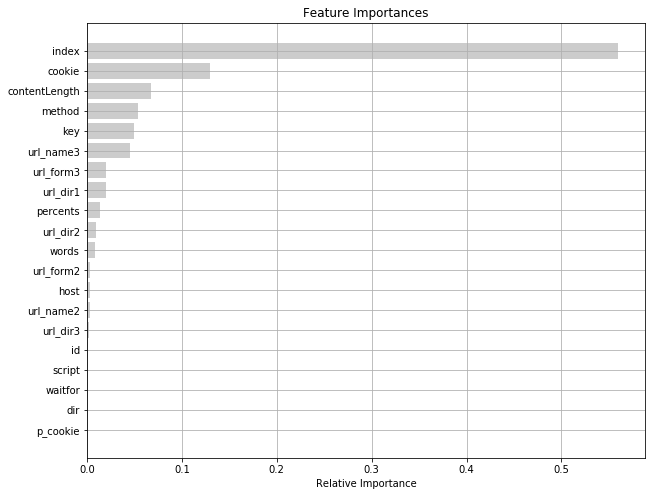

['cookie', 'contentLength', 'method', 'key', 'url_name3', 'url_form3', 'url_dir1', 'percents', 'url_dir2', 'words', 'url_form2', 'host', 'url_name2', 'url_dir3', 'id', 'script', 'waitfor', 'dir', 'p_cookie', 'del', 'and', 'alert', 'delay', 'any']


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

d = pd.read_csv('diplomdata.csv', sep =';') #считываем данные
X = d.drop(['label'], axis = 1)
y = d['label']
# разбиваем на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#анализируем важность признаков
clf = DecisionTreeClassifier(random_state = 0) #дерево решений
clf = clf.fit(X_train, y_train)
results = cross_val_score(clf, X_train, y_train, cv = 5)
print('cross_val: ', results.mean()) #оценка кросс валидации
importances = clf.feature_importances_
print('importance of each feature: ')
indices = np.argsort(importances)[::-1]
for idx, i in enumerate(indices[:30]):
    print("{}.\t{} - {}".format(idx, X_train.columns[i], importances[i])) #Важность признаков
    
#модель случайного леса
rf = RandomForestClassifier(n_estimators = 120, random_state = 42, oob_score = True)
rf.fit(X_train, y_train)
print("Training accuracy: {:.2f} \n Validation accuracy: {:.2f} \nOut-of-bag accuracy: {:.2f}".format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
webatt_f = [] #важные параметры
for index, i in enumerate(indices[:30]):
    webatt_f.append(X.columns[i])
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], X.columns[i]))
    
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (10, 8)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#cccccc', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

#print(confusion_matrix(y_test, rf.predict(X_test))) #отображает количество верно классифицированных элементов и элементов, которые распознались как объекты противоположного класса
max_f = 25
webatt_f = webatt_f[1:max_f] #оставляем важные параметры и исключаем столбец index
print(webatt_f)

['cookie', 'contentLength', 'method', 'key', 'url_name3', 'url_form3', 'url_dir1', 'percents', 'url_dir2', 'words', 'url_form2', 'host', 'url_name2', 'url_dir3', 'id', 'script', 'waitfor', 'dir', 'p_cookie', 'del', 'and', 'alert', 'any']


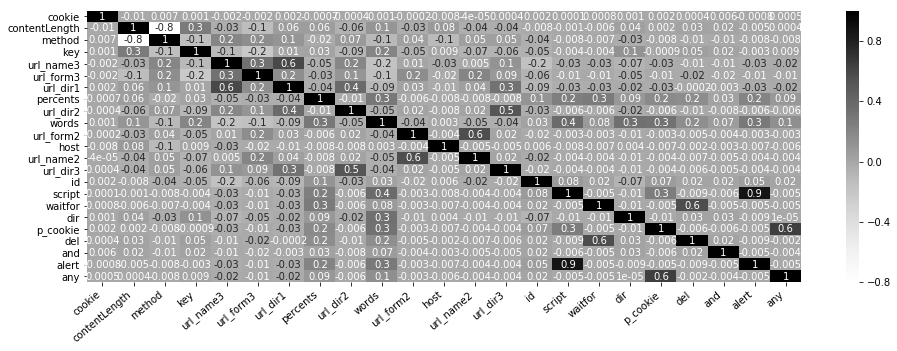

In [16]:
import seaborn as sns
import pandas as pd
import numpy as np

#Сокращение признакового пространства
#корреляция Пирсона  
corr_matrix = d[webatt_f].corr()
plt.rcParams['figure.figsize'] = (16, 5)
g = sns.heatmap(corr_matrix, annot = True, fmt ='.1g', cmap = 'Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment = 'top', horizontalalignment = 'right', rotation = 40);
plt.savefig('corr_heatmap.png', dpi = 300, bbox_inches = 'tight')

to_be_removed = ['delay']
webatt_f = [i for i in webatt_f if i not in to_be_removed]
webatt_f = webatt_f[:23]
print(webatt_f)

In [5]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import time
import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.svm import SVC

from numpy.core.umath_tests import inner1d

#Выбор моделей (5 штук) - 1)kNN 2)Bagg(DTC) 3) Boost(DTC) 4) RFC 5) LR

dat = pd.read_csv('diplomdata.csv', sep =';') #считываем данные

webatt_f = ['cookie', 'contentLength', 'method', 'key', 'url_name3', 'url_form3', 'url_dir1', 'percents', 'url_dir2', 'words', 'url_form2', 'host', 'url_name2', 'url_dir3', 'id', 'script', 'waitfor', 'dir', 'p_cookie', 'del', 'and', 'alert', 'any'] #потом убрать

y = dat['label']
X = dat[webatt_f]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 41)

#params = {'n_neighbors' : [3,4,5,6,7,8],  #находим лучшие параметры для kNN
#          'weights' : ['uniform', 'distance'],
#          'p' : [2,3,4]}
#scoring = {'f1', 'accuracy'}

#knn = KNeighborsClassifier()
#gs = GridSearchCV(knn, params, scoring = scoring, refit='f1', cv = 3, return_train_score=True)
#gs.fit(X_train, y_train)
#print(gs.best_params_) #лучшие параметры для этой модели получились: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

start_time = datetime.datetime.now()
#knn = KNeighborsClassifier(n_neighbors = gs.best_params_['n_neighbors'], weights = gs.best_params_['weights'], p = gs.best_params_['p'])
knn = KNeighborsClassifier(n_neighbors = 3, weights = 'distance', p = 2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"---->Time of kNN, k = 3 : {datetime.datetime.now() - start_time}")
print('accuracy of kNN: ', accuracy_score(y_test, y_pred)) #Доля верных ответов, Accuracy = TP + TN / (TP + TN + FP + FN)
print('precision of kNN: ', precision_score(y_test, y_pred)) #точность, то есть на сколько можно доверять классификатору, Precision = TP / (TP + FP)
print('recall of kNN: ', recall_score(y_test, y_pred)) #как много объектов класса "аномальный трафик" определяет классификатор, Recall = TP / (TP + FN)
print('f1 measure of kNN: ', f1_score(y_test, y_pred)) #гармоническое среднее между точностью и полнотой, F1 = 2 * (precision * recall) / (precision + recall)

#params = {'n_estimators': [10, 25, 50, 75, 100, 125, 150],
#          'max_samples':[0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
#         }

dtc = DecisionTreeClassifier(random_state = 42)
#bagging = BaggingClassifier(base_estimator = dtc, random_state = 41)
#gs = GridSearchCV(bagging, params, scoring = scoring, refit='f1', cv = 3, return_train_score=True)
#gs.fit(X_train, y_train)
#print(gs.best_params_) #лучшие параметры для этой модели

start_time = datetime.datetime.now()
#bagging = BaggingClassifier(base_estimator = dtc, random_state = 41, n_estimators = gs.best_params_['n_estimators'], max_samples = gs.best_params_['max_samples'])
bagging = BaggingClassifier(base_estimator = dtc, random_state = 41, n_estimators = 150, max_samples = 0.9)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
print(f"---->Time of Bag : {datetime.datetime.now() - start_time}")
print('accuracy of Bag: ', accuracy_score(y_test, y_pred)) #Доля верных ответов, Accuracy = TP + TN / (TP + TN + FP + FN)
print('precision of Bag: ', precision_score(y_test, y_pred)) #точность, то есть на сколько можно доверять классификатору, Precision = TP / (TP + FP)
print('recall of Bag: ', recall_score(y_test, y_pred)) #как много объектов класса "аномальный трафик" определяет классификатор, Recall = TP / (TP + FN)
print('f1 measure of Bag: ', f1_score(y_test, y_pred)) #гармоническое среднее между точностью и полнотой, F1 = 2 * (precision * recall) / (precision + recall)

#params = {'n_estimators': [10, 25, 50, 75, 100, 125, 150],
#         'learning_rate':[0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.2]
#         }

#boosting = AdaBoostClassifier(base_estimator = dtc, random_state = 41)
#gs = GridSearchCV(boosting, params, scoring = scoring, refit='f1', cv = 3, return_train_score=True)
#gs.fit(X_train, y_train)
#print(gs.best_params_) #лучшие параметры для этой модели

start_time = datetime.datetime.now()
#boosting = AdaBoostClassifier(base_estimator = dtc, random_state = 41, n_estimators = gs.best_params_['n_estimators'], learning_rate = gs.best_params_['learning_rate'])
boosting = AdaBoostClassifier(base_estimator = dtc, random_state = 41, n_estimators = 10, learning_rate = 0.1)
boosting.fit(X_train, y_train)
y_pred = boosting.predict(X_test)
print(f"---->Time of Boost : {datetime.datetime.now() - start_time}")
print('accuracy of Boost: ', accuracy_score(y_test, y_pred)) #Доля верных ответов, Accuracy = TP + TN / (TP + TN + FP + FN)
print('precision of Boost: ', precision_score(y_test, y_pred)) #точность, то есть на сколько можно доверять классификатору, Precision = TP / (TP + FP)
print('recall of Boost: ', recall_score(y_test, y_pred)) #как много объектов класса "аномальный трафик" определяет классификатор, Recall = TP / (TP + FN)
print('f1 measure of Boost: ', f1_score(y_test, y_pred)) #гармоническое среднее между точностью и полнотой, F1 = 2 * (precision * recall) / (precision + recall)

#params = {'n_estimators': [10, 30, 50, 70, 90],
#              'min_samples_leaf': [3, 5, 7, 9],
#              'max_features': [3, 5, 7, 9, 11], 
#              'max_depth': [ 10, 15, 20, 25]}

#rfc = RandomForestClassifier(random_state = 42)
#gs = GridSearchCV(rfc, params, scoring = scoring, refit='f1', cv = 3, return_train_score=True)
#gs.fit(X_train, y_train)
#print(gs.best_params_) #лучшие параметры для этой модели

start_time = datetime.datetime.now()
#rfc = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'], min_samples_leaf = gs.best_params_['min_samples_leaf'], max_features = gs.best_params_['max_features'], max_depth = gs.best_params_['max_depth'], random_state = 42)
rfc = RandomForestClassifier(n_estimators = 50, min_samples_leaf = 3, max_features = 11, max_depth = 25, random_state = 42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f"---->Time of RFC : {datetime.datetime.now() - start_time}")
print('accuracy of RFC: ', accuracy_score(y_test, y_pred)) #Доля верных ответов, Accuracy = TP + TN / (TP + TN + FP + FN)
print('precision of RFC: ', precision_score(y_test, y_pred)) #точность, то есть на сколько можно доверять классификатору, Precision = TP / (TP + FP)
print('recall of RFC: ', recall_score(y_test, y_pred)) #как много объектов класса "аномальный трафик" определяет классификатор, Recall = TP / (TP + FN)
print('f1 measure of RFC: ', f1_score(y_test, y_pred)) #гармоническое среднее между точностью и полнотой, F1 = 2 * (precision * recall) / (precision + recall)

#params = {'tol': [0.001, 0.0001, 0.00001, 0.000001, 0.0000001],
#          'C': [0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 1.7, 2.0],
#          'intercept_scaling': [0.7, 1.0, 1.3, 1.5, 1.7, 2.0], 
#          'max_iter': [10, 25, 50, 75, 100, 125]}

#lr = LogisticRegression(random_state = 42)
#gs = GridSearchCV(lr, params, scoring = scoring, refit='f1', cv = 3, return_train_score=True)
#gs.fit(X_train, y_train)
#print(gs.best_params_) #лучшие параметры для этой модели

start_time = datetime.datetime.now()
#lr = LogisticRegression(tol = gs.best_params_['tol'], C = gs.best_params_['C'], intercept_scaling = gs.best_params_['intercept_scaling'], max_iter = gs.best_params_['max_iter'], random_state = 42)
lr = LogisticRegression(tol = 0.00001, C = 1.0, intercept_scaling = 1.3, max_iter = 50, random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"---->Time of LR : {datetime.datetime.now() - start_time}")
print('accuracy of LR: ', accuracy_score(y_test, y_pred)) #Доля верных ответов, Accuracy = TP + TN / (TP + TN + FP + FN)
print('precision of LR: ', precision_score(y_test, y_pred)) #точность, то есть на сколько можно доверять классификатору, Precision = TP / (TP + FP)
print('recall of LR: ', recall_score(y_test, y_pred)) #как много объектов класса "аномальный трафик" определяет классификатор, Recall = TP / (TP + FN)
print('f1 measure of LR: ', f1_score(y_test, y_pred)) #гармоническое среднее между точностью и полнотой, F1 = 2 * (precision * recall) / (precision + recall)



---->Time of kNN, k = 3 : 0:00:02.058240
accuracy of kNN:  0.9144701532589898
precision of kNN:  0.9259848786311182
recall of kNN:  0.9122679286494357
f1 measure of kNN:  0.9190752260448846
---->Time of Bag : 0:02:16.666792
accuracy of Bag:  0.9103852346591925
precision of Bag:  0.91378733838609
recall of Bag:  0.9183164851166308
f1 measure of Bag:  0.9160463134959986
---->Time of Boost : 0:00:01.796266
accuracy of Boost:  0.9013507066611008
precision of Boost:  0.9071140714205754
recall of Boost:  0.9076475035703284
f1 measure of Boost:  0.9073807090967624
---->Time of RFC : 0:00:18.377410
accuracy of RFC:  0.736597292623293
precision of RFC:  0.708218893530593
recall of RFC:  0.8592590518327686
f1 measure of RFC:  0.7764619550089831
---->Time of LR : 0:00:02.766746
accuracy of LR:  0.6088168644522631
precision of LR:  0.6016963710543268
recall of LR:  0.7846601887373639
f1 measure of LR:  0.6811049938624956
